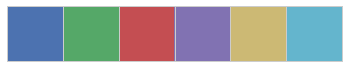

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import scipy.stats as ss
import collections
import corner
import seaborn as sns
pd.options.mode.chained_assignment = None
%matplotlib inline
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)
sns.set()
sns.set_style("whitegrid")
reso=300
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [2]:
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.
    Richard M. Brugger, "A Note on Unbiased Estimation of the Standard Deviation", The American Statistician (23) 4 p. 32 (1969)

    values, weights -- Numpy ndarrays with the same shape.
    """
    n=len(values)
    average = np.average(values, weights=weights)
    variance = (n/(n-1.5))*np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return np.sqrt(variance),average

In [4]:
#df=pd.read_csv("NED27.02.1-D-14.1.0-20170227.csv",skiprows=12)
#df=df[np.isnan(df['redshift (z)'])] # only measurements without redshift data are useful here

In [3]:
df=pd.read_csv("NED27.09.1-D-14.2.0-20170929.csv",skiprows=12)
df=df[np.isnan(df['redshift (z)'])] # only measurements without redshift data are useful here

In [4]:
def selectdata_lite(mymethod,df):
    dfa=df[~np.isfinite(df.err)|(df.err==0)] # database of non reported errors
    df1=df[np.isfinite(df.err)] # remove measurements that do not report an error
    df1=df1[df1.err!=0] # remove measurements that report an error as zero ¬¬
# Select a method for analysis
    df1=df1[df1.Method==mymethod] # choose a method
    namelist=list(df1['Galaxy ID']) # list of galaxies
    counter=collections.Counter(namelist) # count measurements per galaxy
# Select galaxies with a minimum number of measurements
    ulist=[]
    ulist2=[]
    nmeas=1
    for i in counter.keys():
        if counter[i]>nmeas:
            ulist+=[i] # all galaxies with more than n_meas measurements
        if counter[i]>=1:
            ulist2+=[i] # all galaxies with at least one measurement w/a reported error
    print('No. of Galaxies with reported errors is %i' % len(ulist2) )
    print('No. of Galaxies with more than %i measurements is %i' % (nmeas,len(ulist)) )
# Create database for bootstrap, remove unnecessary columns
    dfs=df1[np.in1d(df1['Galaxy ID'],ulist)] # dataframe with galaxies with more than nmeas measurements
    colu=list(df.columns)
    for i in ['Galaxy ID', 'm-M', 'err', 'D (Mpc)']:
        colu.remove(i)
    dfs.drop(colu, inplace=True, axis=1)
# Create database for non-reported errors
    df1a=dfa[dfa.Method==mymethod] # all measurements without reported errors
    elist=list(np.unique(df1a['Galaxy ID'])) # list of galaxies with measurements without reported errors
#    dmeana=[]
#    for i in elist:
#        dfilter=np.in1d(df1a['Galaxy ID'],i)
#        dummy=df1a[dfilter]
#        dmeana+=[dummy['D (Mpc)'].mean()] # average reported distance (D), no need for weighted... there are no weights
    filtr=~np.in1d(elist,ulist2) # select only galaxies with no additional measurements using the same method
    nulista=np.asarray(elist)[filtr] # list of galaxies without reported errors
#    dista=np.asarray(dmeana)[filtr] # mean distance of galaxies without reported errors
    print('No. of Galaxies without reported errors is %i' % len(nulista) )
    return ulist,dfs,nulista,len(nulista),len(ulist),len(ulist2)

In [5]:
mymethod='FP'
ulist,dfs,nulista,*mma=selectdata_lite(mymethod,df)

No. of Galaxies with reported errors is 129054
No. of Galaxies with more than 1 measurements is 1218
No. of Galaxies without reported errors is 25


In [7]:
%%time
np.random.seed(10)
nbins=10000 # 1e4 -> 4 minutes
em=[] # number of measurements per galaxy
bootp50=[] # mean error from the bootstrap for each galaxy
bootmsig=[]
bootmother=[]
bootsig=[] # uncertainty of the error -> may not be a good predictor
dboot=[] # mean bootstrap distance
bootmad=[] # median absolute deviation (robust)
wsnt=[] # error propagated from the weighted standard deviation of the distance modulus (natural way to do it)
dwa=[] # distance using weighted average of modulus and err (for show mostly)
ecf=[]
eqd=[]
for i in ulist:
    dfilter=np.in1d(dfs['Galaxy ID'],i)
    dummy=dfs[dfilter]
    em+=[len(dummy)] # n_meas, number of measurements per galaxy
    tli=[]
    for km,ke in zip(dummy['m-M'],dummy['err']):
        tli+=[list(10**(np.random.normal(km,ke,nbins)/5.+1))] # bootstrap draw for each gal
    tli=np.array(tli)
    booterr=(np.percentile(tli, 84,axis=0)-np.percentile(tli, 16,axis=0))/2 # sigma draws from bootstrap for each gal
    bootmean=np.median(tli,axis=0) # mean draws from bootstrap for each gal
############## This block should be ran for 10k draws ###############
#    mymed=np.median(tli,axis=0) #median for error of m error
#    mst=[np.median(np.abs(tli[:,kk]-mymed[kk])) for kk in range(nbins)]
#    bootmsig+=[(np.percentile(mst, 84,axis=0)-np.percentile(mst, 16,axis=0))/2e6] # error of m error
#    bootmother+=[np.median(mst)/1e6]
#####################################################################
    bootp50+=[np.median(booterr)/1e6] # mean bootstrap error
    bootsig+=[((np.percentile(booterr, 84)-np.percentile(booterr, 16)))/2e6] # the error of the error
    bootmad+=[np.median(np.abs(tli - np.median(tli)))/1e6]
    dboot+=[np.median(bootmean)/1e6] # bootstrap mean D
    wnat,avnat = weighted_std(dummy['m-M'],1/dummy['err']**2)
    distwav=10**(avnat/5+1)/1e6
    dwa+=[distwav] #
    wsti=0.461*distwav*wnat # weighted standard deviation
    wsnt+=[wsti] 
    ecfi=0.461*distwav/np.sqrt((1/dummy['err']**2).sum()) # error according to cosmicflows
    ecf+=[ecfi]
    eqd+=[np.sqrt(ecfi**2+wsti**2)]    
# weighted std using D and propagated err is similar to propagated D error using weighted std on modulus and error

CPU times: user 8.92 s, sys: 0 ns, total: 8.92 s
Wall time: 8.93 s


In [23]:
#mulist=[i.replace(" ", "") for i in ulist]
#np.savetxt('calculated.txt',np.array(mulist),fmt='%s')

### Do not re-write bootstrap results by executing the next couple of cells. For emergencies only!

In [170]:
d = {'names': ulist, 'meas': em, 'bootp50':bootp50, 'bootsig':bootsig,'dboot':dboot,'wsnt':wsnt,'dwa':dwa,'ecf':ecf,'eqd':eqd,'bootmad':bootmad}
dfb = pd.DataFrame(data=d)
dfb.to_csv("bootstrap_results.csv")

In [168]:
d = {'names': ulist, 'meas': em, 'bootmad':bootmad,'bootmsig':bootmsig,'bootmother':bootmother}
dfm = pd.DataFrame(data=d)
dfm.to_csv("bootstrap_results_wm.csv")

### Continue from here

In [2]:
ndf=pd.read_csv("bootstrap_results.csv")
bdf=pd.read_csv("bootstrap_results_wm.csv")
em=ndf.meas
dboot=ndf.dboot
dwa=ndf.dwa
bootp50=ndf.bootp50
wsnt=ndf.wsnt
ecf=ndf.ecf
eqd=ndf.eqd
bootmad=ndf.bootmad
bootsig=ndf.bootsig
bootmsig=bdf.bootmsig
bootmother=bdf.bootmother

In [8]:
np.unique(em)

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [10]:
filt=(np.array(em)<6)|(np.array(em)>1)
x=np.array(dboot)[filt]
xa=np.array(dwa)[filt]
y=np.array(bootp50)[filt]
w=np.array(wsnt)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]
ee=np.array(bootsig)[filt]
#ms=np.array(bootmsig)[filt]
#mo=np.array(bootmother)[filt]

(-5, 120)

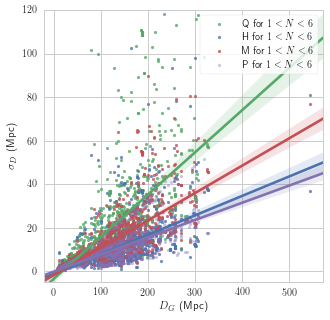

In [11]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1], scatter_kws={'alpha':0.8,'s':10},label='Q for $1<N<6$') # green, quadrature
sns.regplot(x,y,color=current_palette[0],label=r'H for $1<N<6$', scatter_kws={'s':10})
sns.regplot(x,z,color=current_palette[2],label='M for $1<N<6$', scatter_kws={'alpha':0.8,'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $1<N<6$') # red, cosmicflows
plt.legend(loc='upper right',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.ylim(-5,120)
#plt.savefig('mnras/hqmlow.pdf', dpi=reso,transparent=True)
#plt.savefig('mnras/hqmlow.png', dpi=reso,transparent=True)

In [33]:
filt=np.array(em)>1
x=np.array(dboot)[filt]
xa=np.array(dwa)[filt]
y=np.array(bootp50)[filt]
w=np.array(wsnt)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]
ee=np.array(bootsig)[filt]
#ms=np.array(bootmsig)[filt]
#mo=np.array(bootmother)[filt]

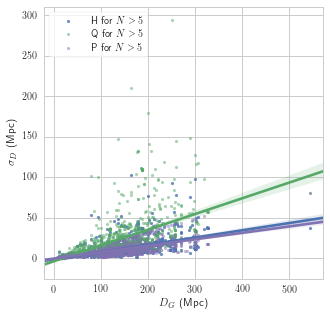

In [34]:
plt.figure(figsize=(5,5))
sns.regplot(x,y,label='H for $N>5$', scatter_kws={'s':10})
sns.regplot(x,qd, scatter_kws={'alpha':0.5,'s':10},label='Q for $N>5$') # green, quadrature
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.5,'s':10},label='P for $N>5$') # purple, cosmicflows
#sns.regplot(x,z, scatter_kws={'alpha':0.3}) # purple, mad
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
#plt.savefig('mnras/hqp.pdf', dpi=reso,transparent=True)
#plt.savefig('mnras/hqp.png', dpi=reso,transparent=True)

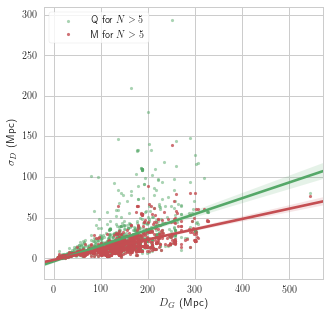

In [35]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1],label='Q for $N>5$', scatter_kws={'alpha':0.5,'s':10}) 
sns.regplot(x,z,color=current_palette[2],label='M for $N>5$', scatter_kws={'alpha':0.8,'s':10}) # red, MAD
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
#plt.savefig('mnras/qm.pdf', dpi=reso,transparent=True)
#plt.savefig('mnras/qm.png', dpi=reso,transparent=True)

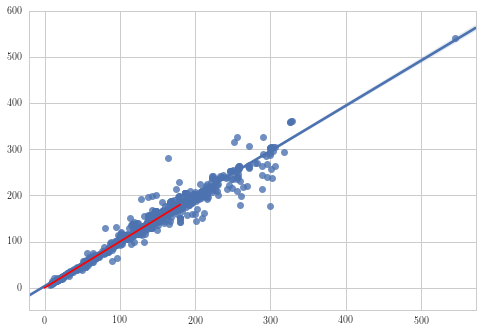

In [36]:
sns.regplot(x,xa)
plt.plot([0,180],[0,180],c='r')

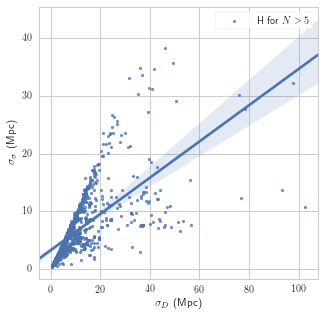

In [37]:
plt.figure(figsize=(5,5))
sns.regplot(y,ee,color=current_palette[0], scatter_kws={'s':10},label='H  for $N>5$') # error of the error
#sns.regplot(z,ms,color=current_palette[2], scatter_kws={'alpha':0.5,'s':10},label='M for $N>5$') # error of the error

plt.xlabel(r"$\sigma_D$ (Mpc)")
plt.ylabel(r'$\sigma_\sigma$ (Mpc)')
plt.legend(frameon=True)
#plt.savefig('mnras/ee.pdf', dpi=reso,transparent=True)
#plt.savefig('mnras/ee.png', dpi=reso,transparent=True)

(array([ 123.,   69.,   79.,  164.,  250.,  194.,  154.,   84.,   33.,
          33.,   25.,    9.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    1.]),
 array([   6.60027979,   33.53784334,   60.47540689,   87.41297044,
         114.35053399,  141.28809754,  168.22566109,  195.16322464,
         222.10078819,  249.03835174,  275.97591529,  302.91347884,
         329.85104239,  356.78860594,  383.72616949,  410.66373304,
         437.60129659,  464.53886014,  491.47642369,  518.41398724,
         545.35155079]),
 <a list of 20 Patch objects>)

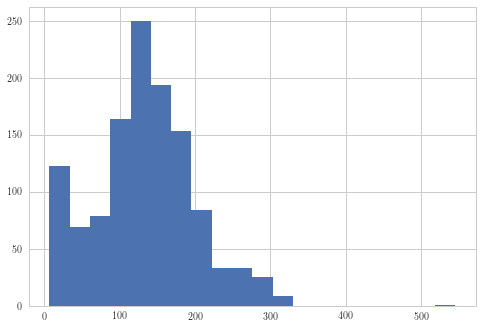

In [38]:
plt.hist(x,bins=20)

# Working Models

## Linear Model

Works for n_meas > 14 (468 galaxies), but discrepancy plot shows different distributions for simulated and observed discrepancies. $\sigma_B$ is the bootstrap-obtained (real) error, $\sigma_{SW}$ is the sigma used for statistical weight in likelihood.

$$\sigma_B=mD+b $$
$$\sigma_{SW}=f\sigma_B$$

We don't like it because it is not super-physical. Also, it's better not to use $\sigma_\sigma$, as we do not have it for empty measurements. We should also look at empty measurements for galaxies that have other measurements.

In [45]:
def lnlike2(theta, x, y):# modelo que usa una fracción de sigma como peso estadistico
    m ,b, f = theta
    model = m * x + b    
    inv_sigma2 = 1.0/((f*model)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior2(theta):
    m, b, f = theta
    if 0 < m < 5 and 0 < b < 5 and 0 < f < 1:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob2(theta, x, y):
    lp = lnprior2(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike2(theta, x, y)

def discrep2(ii,samples,x,y):
    discs=[]
    disco=[]
    rej=0
    ndisc=len(samples)//100
    for i in range(ndisc):
        yexp=samples[i,0]*x+samples[i,1]
        modpar=samples[np.random.randint(len(samples))]
        ysim=np.random.normal(modpar[0]*x+modpar[1],(modpar[0]*x+modpar[1])*modpar[2])
        if np.any(ysim<0)|np.any(ysim<0):
            rej+=1
        else:        
#            yexp=np.sqrt(yexp)
#            ysim=np.sqrt(ysim)
#            y=np.sqrt(y)
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()]
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()]
    print("Rejection rate =",100*rej//ndisc,"%") # rejection rate
    if 100*rej//ndisc < 100:
        discs=np.array(discs)
        disco=np.array(disco)
#        plt.figure(figsize=(6,6))
        plt.scatter(disco,discs,alpha=0.4,label=r"$N>$ "+str(ii)+", Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
        dmax=np.max(np.hstack((disco,discs)))
        dmin=np.min(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax+10,2)
        plt.plot(ppp,ppp,c='r')
#        plt.xlim(dmin,dmax)
#        plt.ylim(dmin,dmax)
        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))
#        return ppp,discs,disco

28
3 0.190873403465 1.60857829186 0.456684069143
3 [ 0.18701868  1.79177866  0.49940376]
Rejection rate = 46 %
Bayesian p-value: 0.464583333333
16
4 0.229375249435 2.21386356426 0.330426704994
4 [ 0.22688973  2.33376952  0.38856035]
Rejection rate = 12 %
Bayesian p-value: 0.72819216182


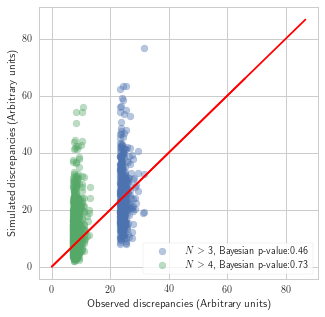

In [60]:
plt.figure(figsize=(5,5))
for i in range(3,5):
    filt=np.array(em)>i
    print(filt.sum())
    x=np.array(dboot)[filt]
    y=np.array(bootp50)[filt]

    nll = lambda *args: -lnlike2(*args)## AQUI
    result = op.minimize(nll, [1.]*3, args=(x, y)) ## AQUI
    m_ml, b_ml,f_ml = result["x"]## AQUI
    print(i,m_ml,b_ml,f_ml)## AQUI
    #    if b_ml > 0:
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=(x, y)) ## AQUI
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    steps=1000
    sampler.run_mcmc(pos, steps);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    sth=samples.mean(axis=0)
#    fig = corner.corner(samples, labels=["$m$", "$b$","$f$"],truths=sth, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
    print(i,sth)
    discrep2(i,samples,x,y)
plt.legend(loc='lower right',frameon=True)
plt.xlabel('Observed discrepancies (Arbitrary units)')
plt.ylabel('Simulated discrepancies (Arbitrary units)')
#plt.xlim(40,110)
#plt.ylim(40,110)
#plt.savefig('mnras/discl.pdf', dpi=reso,transparent=True)
#plt.savefig('mnras/discl.png', dpi=reso,transparent=True)
# store for prediction below
sth1=sth
samples1=samples
x1=x
y1=y

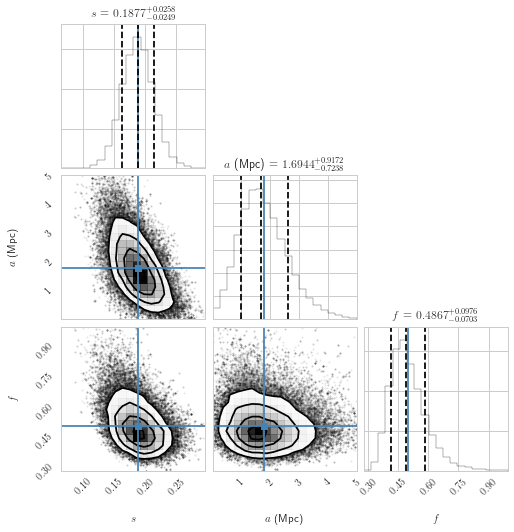

In [47]:
fig = corner.corner(samples, labels=["$s$", "$a$ (Mpc)","$f$"],truths=sth, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
#plt.savefig('mnras/cornerl.pdf', dpi=reso,transparent=True)

(0, 35)

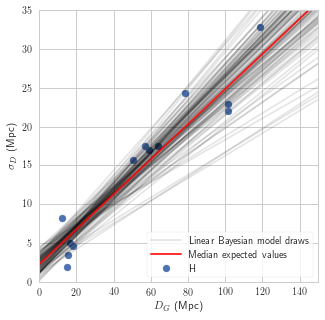

In [64]:
plt.figure(figsize=(5,5))
xl = np.linspace(0,160,2)
sth=np.median(samples,axis=0)
plt.figure(figsize=(5,5))
for m, b,f in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m*xl+b, color="k", alpha=0.1,label="Linear Bayesian model draws")
plt.scatter(x,y,label='H')
plt.plot(xl, sth[0]*xl+sth[1], color="r", lw=2, alpha=0.8,label="Median expected values")
plt.legend(frameon=True)
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(0,150)
plt.ylim(0,35)
#plt.savefig('mnras/drawsl.pdf', dpi=reso,transparent=True)

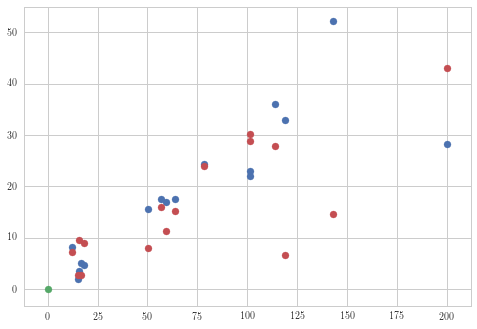

In [67]:
modpar=samples[np.random.randint(len(samples))]
ysim=np.random.normal(modpar[0]*x+modpar[1],modpar[2]*(modpar[0]*x+modpar[1]))
plt.scatter(x,y)
plt.scatter([0],[0])
plt.scatter(x,ysim)

39.3634689641 9.86846725598
39.740863478 10.3358734451
38.6818842473 10.042006284


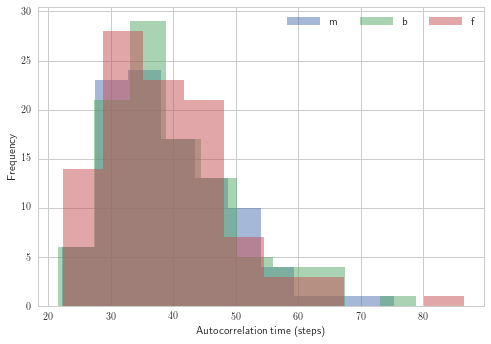

In [281]:
for j in range(3):
    autocorr=[]
    for i in range(100):
        autocorr.append(emcee.autocorr.integrated_time(sampler.chain[i,:,j],c=5))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)

    print(autocorr.mean(),autocorr.std())
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
           ['m','b','f'],
           scatterpoints=1,
           loc='upper right',
           ncol=4,
           fontsize=11)

1175
11 0.139036160764 0.607727724318 0.216737687043
11 [ 0.13902342  0.60835865  0.21712406]
Rejection rate = 0 %
Bayesian p-value: 0.997771700598
921
12 0.141500007846 0.545307133755 0.225559692686
12 [ 0.14144985  0.54668197  0.22613924]
Rejection rate = 0 %
Bayesian p-value: 0.938082691528
727
13 0.141714718689 0.52743822426 0.227190002502
13 [ 0.14166508  0.52924037  0.22793585]
Rejection rate = 0 %
Bayesian p-value: 0.596995228911


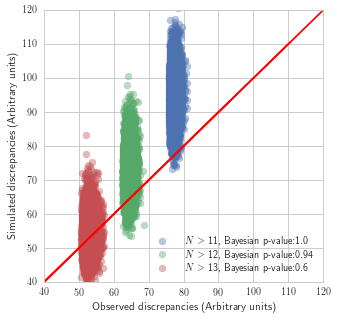

In [231]:
plt.figure(figsize=(5,5))
for i in range(11,14):
    filt=np.array(em)>i
    print(filt.sum())
    x=np.array(dboot)[filt]
    y=np.array(bootmad)[filt]

    nll = lambda *args: -lnlike2(*args)## AQUI
    result = op.minimize(nll, [1.]*3, args=(x, y)) ## AQUI
    m_ml, b_ml,f_ml = result["x"]## AQUI
    print(i,m_ml,b_ml,f_ml)## AQUI
    #    if b_ml > 0:
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=(x, y)) ## AQUI
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    steps=10000
    sampler.run_mcmc(pos, steps);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    sth=samples.mean(axis=0)
    #fig = corner.corner(samples, labels=["$m$", "$b$","$f$"],truths=sth, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
    print(i,sth)
    discrep2(i,samples,x,y)
plt.legend(loc='lower right')
plt.xlabel('Observed discrepancies (Arbitrary units)')
plt.ylabel('Simulated discrepancies (Arbitrary units)')
plt.xlim(40,120)
plt.ylim(40,120)
plt.savefig('mnras/discl2.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/discl2.png', dpi=reso,transparent=True)
# store for prediction below
sth2=sth
samples2=samples
x2=x
y2=y

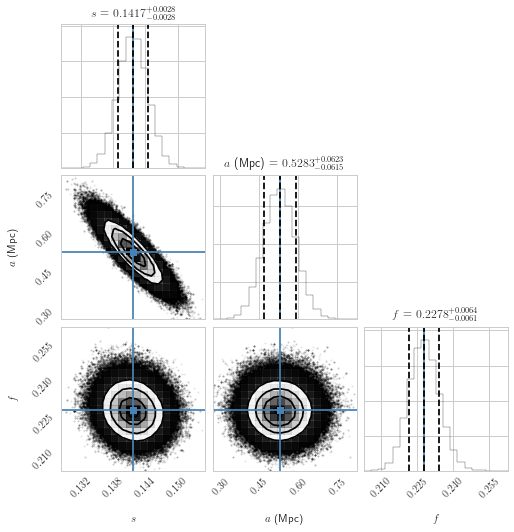

In [302]:
fig = corner.corner(samples, labels=["$s$", "$a$ (Mpc)","$f$"],truths=sth, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
plt.savefig('mnras/cornerl2.pdf', dpi=reso,transparent=True)

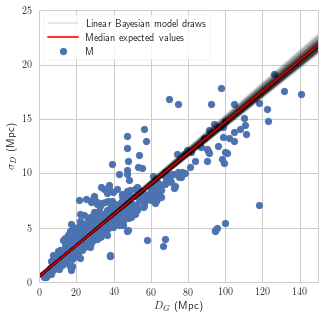

In [26]:
plt.figure(figsize=(5,5))
xl = np.linspace(0,160,2)
sth=np.median(samples,axis=0)

for m, b,f in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m*xl+b, color="k", alpha=0.1,label="Linear Bayesian model draws")
plt.scatter(x,y,label='M')
plt.plot(xl, sth[0]*xl+sth[1], color="r", lw=2, alpha=0.8,label="Median expected values")
plt.legend(frameon=True)
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(0,150)
plt.ylim(0,25)
plt.savefig('mnras/drawsl2.pdf', dpi=reso,transparent=True)

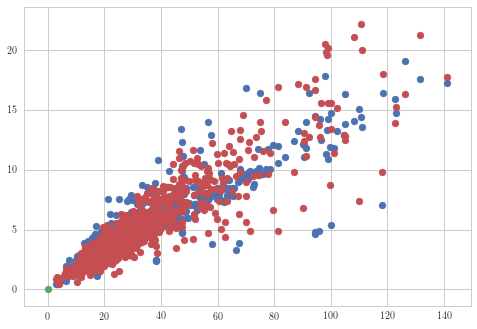

In [233]:
modpar=samples[np.random.randint(len(samples))]
ysim=np.random.normal(modpar[0]*x+modpar[1],modpar[2]*(modpar[0]*x+modpar[1]))
plt.scatter(x,y)
plt.scatter([0],[0])
plt.scatter(x,ysim)

37.9219577972 8.65518374237
37.9263070078 7.5611755627
40.0596392275 9.2995938277


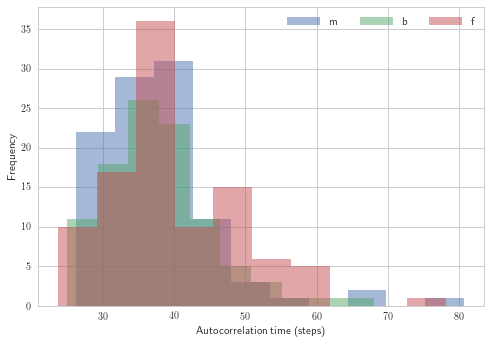

In [286]:
for j in range(3):
    autocorr=[]
    for i in range(100):
        autocorr.append(emcee.autocorr.integrated_time(sampler.chain[i,:,j],c=5))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)

    print(autocorr.mean(),autocorr.std())
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
           ['m','b','f'],
           scatterpoints=1,
           loc='upper right',
           ncol=4,
           fontsize=11)

## Quadrature

$$\sigma_D=\sqrt{(mD+c)^2+b^2 }$$
$$\sigma_{SW}=f\sigma_D$$
Quadrature model with multiplicative and additive terms in systematic error. It shows numerical instability due to the degeneracy between the zero offset error and the random error.


If an additive term is added to the systematic error, we go back to the linear model, as $b$ goes to zero in the MCMC.

In [7]:
def lnlike4(theta, x, y):# modelo que usa una fracción de sigma_sigma
    m ,b,f,c = theta
    model = np.sqrt((m*x+c)**2+ b**2)
    inv_sigma2 = 1.0/(f*model)**2
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior4(theta):
    m, b, f,c = theta
    if 0 < m < 1 and -10 < b < 10 and 0 < f < 1 and 0 < c < 10:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob4(theta, x, y):
    lp = lnprior4(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike4(theta, x, y)

def discrep4(ii,samples,x,y):
    discs=[]
    disco=[]
    rej=0
    ndisc=len(samples)//100
    for i in range(ndisc):
        yexp=(samples[i,0]*x+samples[i,3])**2+samples[i,1]**2
        yexp=np.sqrt(yexp)
        modpar=samples[np.random.randint(len(samples))]
        ymod=(modpar[0]*x+modpar[3])**2+modpar[1]**2
        ymod=np.sqrt(ymod)
        ysim=np.random.normal(ymod,modpar[2]*ymod)
        if np.any(yexp<0)|np.any(ysim<0):
            rej+=1
        else:        
#            ysim=np.sqrt(ysim)
#            y=np.sqrt(y)
#            discs+=[((ysim-yexp)**2).sum()]
#            disco+=[((y-yexp)**2).sum()]
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()]
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()]
    print("Rejection rate =",100*rej//ndisc,"%") # rejection rate
    if 100*rej//ndisc < 100:
        discs=np.array(discs)
        disco=np.array(disco)
        plt.scatter(disco,discs,alpha=0.4,label=r"$N>$ "+str(ii)+", Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
        dmax=np.max(np.hstack((disco,discs)))
        dmin=np.min(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax+10,2)
        plt.plot(ppp,ppp,c='r')
#        plt.xlim(dmin,dmax)
#        plt.ylim(dmin,dmax)
        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

69
23 0.229056202783 -2.02771906639e-07 0.247664874657 0.514031842813
23 [ 0.22486157 -0.00814874  0.25675276  0.50444071]
Rejection rate = 0 %
Bayesian p-value: 0.045584045584
48
24 0.253686376524 -5.16539967972e-08 0.252215341277 0.185607102276
24 [ 0.23365136  0.00469476  0.26648221  0.43567692]
Rejection rate = 0 %
Bayesian p-value: 0.117455138662
29
25 0.265260662006 -3.67596973305e-06 0.224478085503 0.201414884943
25 [ 0.23438381 -0.00874537  0.24576848  0.58340072]
Rejection rate = 0 %
Bayesian p-value: 0.727918421186


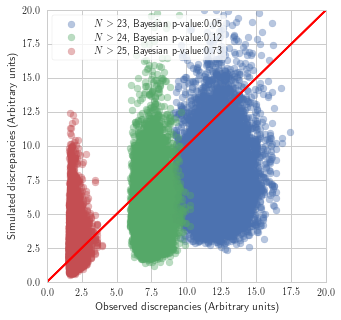

In [212]:
plt.figure(figsize=(5,5))
for i in range(23,26):
    filt=np.array(em)>i
    print(filt.sum())
    xx=np.array(dboot)[filt]
    yy=np.array(bootp50)[filt]
    #y=np.array(bootmad)[filt]
    #yy=yy**2
    nll = lambda *args: -lnlike4(*args)## AQUI
    result = op.minimize(nll, [1.]*4, args=(xx, yy)) ## AQUI
    m_ml, b_ml,f_ml,c_ml = result["x"]## AQUI
    print(i,m_ml,b_ml,f_ml,c_ml)## AQUI
    #    if b_ml > 0:
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    samplerq = emcee.EnsembleSampler(nwalkers, ndim, lnprob4, args=(xx, yy)) ## AQUI
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    steps=20000
    samplerq.run_mcmc(pos, steps);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samplesq = samplerq.chain[:, 200:, :].reshape((-1, ndim)) 
    sthq=samplesq.mean(axis=0)
#    fig = corner.corner(samplesq, labels=["$s^2$", "$\sigma_r$ (Mpc)","$f$","$a$ (Mpc)"],truths=sthq, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
    print(i,sthq)
    discrep4(i,samplesq,xx,yy)
plt.legend(loc='upper left',frameon=True)
plt.xlabel('Observed discrepancies (Arbitrary units)')
plt.ylabel('Simulated discrepancies (Arbitrary units)')
plt.xlim(0,20)
plt.ylim(0,20)
plt.savefig('mnras/discq.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/discq.png', dpi=reso,transparent=True)

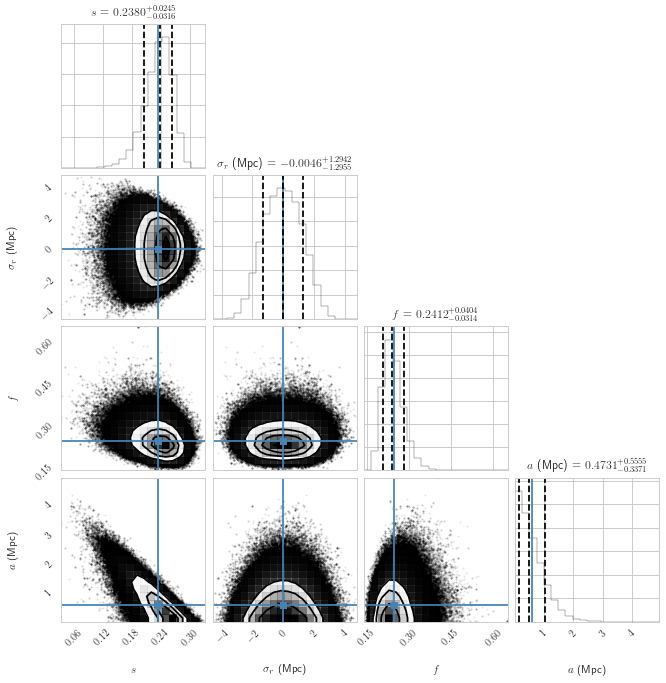

In [289]:
fig = corner.corner(samplesq, labels=["$s$", "$\sigma_r$ (Mpc)","$f$","$a$ (Mpc)"],truths=sthq, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
plt.savefig('mnras/cornerq.pdf', dpi=reso,transparent=True)

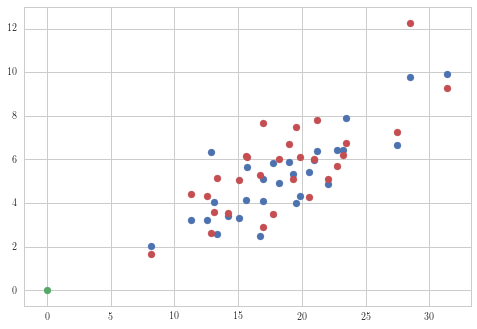

In [224]:
modparq=samplesq[np.random.randint(len(samplesq))]
ymod=np.sqrt((modparq[0]*xx+modparq[3])**2+modparq[1]**2)
ysim=np.random.normal(ymod,modparq[2]*ymod)
plt.scatter(xx,yy)
plt.scatter([0],[0])
plt.scatter(xx,ysim)

62.6686438992 10.9713686185
86.7087838729 15.9718456084
59.3360377746 8.84547630071
65.9754235963 15.7099277113


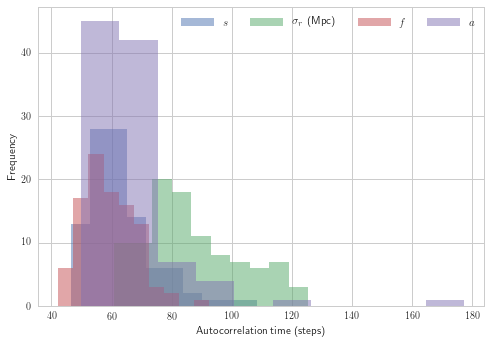

In [291]:
for j in range(4):
    autocorr=[]
    for i in range(100):
        autocorr.append(emcee.autocorr.integrated_time(samplerq.chain[i,:,j],c=3))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)

    print(autocorr.mean(),autocorr.std())
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
           ["$s$", r"$\sigma_r$ (Mpc)","$f$","$a$"],
           scatterpoints=1,
           loc='upper right',
           ncol=4,
           fontsize=11)

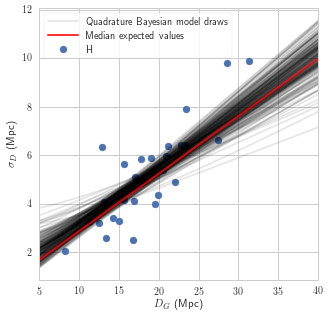

In [292]:
plt.figure(figsize=(5,5))
plt.scatter(xx,yy,label="H")
xl = np.linspace(5,40,2000)
sthq=np.median(samplesq,axis=0)

for m, b,f,c in samplesq[np.random.randint(len(samplesq), size=200)]:
    plt.plot(xl, np.sqrt((m*xl+c)**2+b**2), color="k", alpha=0.1)
plt.plot(xl, np.sqrt((m*xl+c)**2+b**2), color="k", alpha=0.1,label="Quadrature Bayesian model draws")
plt.plot(xl, np.sqrt((sthq[0]*xl+sthq[3])**2+sthq[1]**2), color="r", lw=2, alpha=0.8,label="Median expected values")
plt.legend(frameon=True)
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(5,40)
plt.savefig('mnras/drawsq.pdf', dpi=reso,transparent=True)

921
12 0.141500005784 4.8439344709e-08 0.225559697414 0.545307176212
12 [ 0.14151574  0.00096884  0.22623654  0.54043126]
Rejection rate = 0 %
Bayesian p-value: 0.937557112397
727
13 0.141714717192 -9.6389619157e-08 0.227190004661 0.527438249239
13 [ 0.14174248 -0.00174334  0.22804355  0.52081607]
Rejection rate = 0 %
Bayesian p-value: 0.59443259169


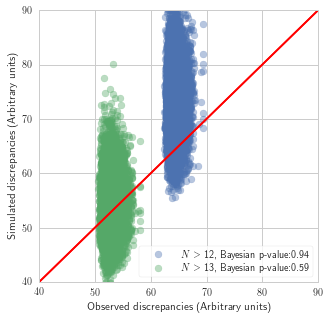

In [213]:
plt.figure(figsize=(5,5))
for i in range(12,14):
    filt=np.array(em)>i
    print(filt.sum())
    xx=np.array(dboot)[filt]
#    yy=np.array(bootp50)[filt]
    yy=np.array(bootmad)[filt]
    #yy=yy**2
    nll = lambda *args: -lnlike4(*args)## AQUI
    result = op.minimize(nll, [1.]*4, args=(xx, yy)) ## AQUI
    m_ml, b_ml,f_ml,c_ml = result["x"]## AQUI
    print(i,m_ml,b_ml,f_ml,c_ml)## AQUI
    #    if b_ml > 0:
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    samplerq = emcee.EnsembleSampler(nwalkers, ndim, lnprob4, args=(xx, yy)) ## AQUI
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    steps=10000
    samplerq.run_mcmc(pos, steps);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samplesq = samplerq.chain[:, 120:, :].reshape((-1, ndim)) 
    sthq=samplesq.mean(axis=0)
#    fig = corner.corner(samplesq, labels=["$s^2$", "$\sigma_r$ (Mpc)","$f$","$a$ (Mpc)"],truths=sthq, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
    print(i,sthq)
    discrep4(i,samplesq,xx,yy)
plt.legend(loc='lower right',frameon=True)
plt.xlabel('Observed discrepancies (Arbitrary units)')
plt.ylabel('Simulated discrepancies (Arbitrary units)')
plt.xlim(40,90)
plt.ylim(40,90)
plt.savefig('mnras/discq2.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/discq2.png', dpi=reso,transparent=True)

49.2777841864 15.0381212091
52.3062210525 15.4068886943
48.7257436084 13.9015018787
48.5566029146 12.8674399706


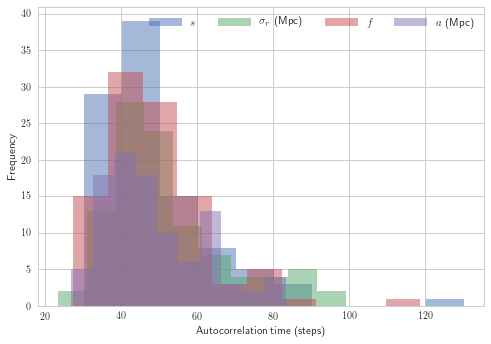

In [9]:
for j in range(4):
    autocorr=[]
    for i in range(100):
        autocorr.append(emcee.autocorr.integrated_time(samplerq.chain[i,:,j],c=5))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)

    print(autocorr.mean(),autocorr.std())
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
           ["$s$", r"$\sigma_r$ (Mpc)","$f$","$a$ (Mpc)"],
           scatterpoints=1,
           loc='upper right',
           ncol=4,
           fontsize=11)

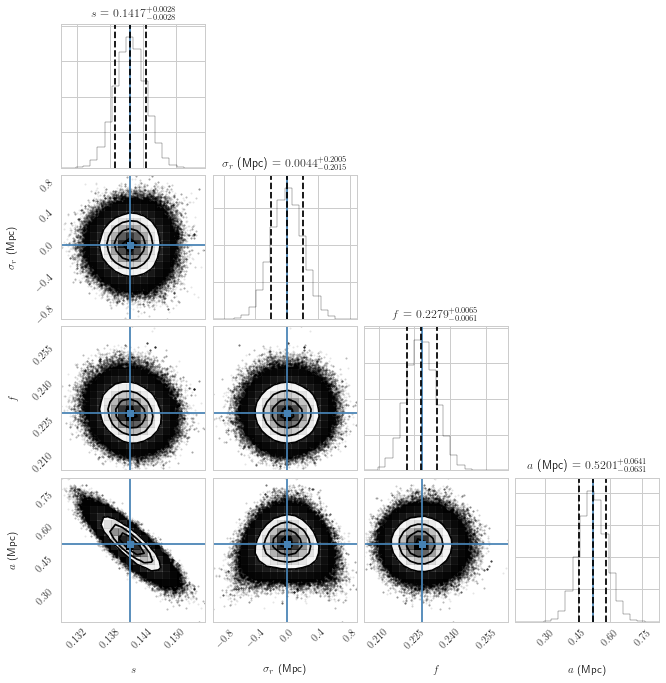

In [10]:
fig = corner.corner(samplesq, labels=["$s$", "$\sigma_r$ (Mpc)","$f$","$a$ (Mpc)"],truths=sthq, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
plt.savefig('mnras/cornerq2.pdf', dpi=reso,transparent=True)

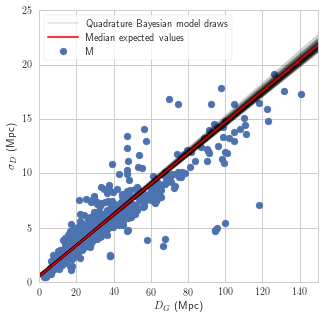

In [11]:
plt.figure(figsize=(5,5))
plt.scatter(xx,yy,label="M")
sthq=np.median(samplesq,axis=0)
xl = np.linspace(0,150,200)
for m, b,f,c in samplesq[np.random.randint(len(samplesq), size=100)]:
    plt.plot(xl, np.sqrt((m*xl+c)**2+b**2), color="k", alpha=0.1)
plt.plot(xl, np.sqrt((m*xl+c)**2+b**2), color="k", alpha=0.1,label="Quadrature Bayesian model draws")
plt.plot(xl, np.sqrt((sthq[0]*xl+sthq[3])**2+sthq[1]**2), color="r", lw=2, alpha=0.8,label="Median expected values")
plt.legend(frameon=True)
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(0,150)
plt.ylim(0,25)
plt.savefig('mnras/drawsq2.pdf', dpi=reso,transparent=True)

In [50]:
odf=df[np.in1d(df['Galaxy ID'],nulista)] # nulista has names of galaxies for which all measurements are error-less
odf=odf[odf.Method=='Tully-Fisher']

In [51]:
meddist=[]
for i in nulista:
    dummy=odf[odf['Galaxy ID']==i]
    meddist+=[np.median(dummy['D (Mpc)'])]
meddist=np.array(meddist)

In [52]:
len(meddist)

818

(array([ 318.,  180.,  126.,   84.,   42.,   31.,   25.,    9.,    0.,    3.]),
 array([  7.66000000e-02,   2.70689400e+01,   5.40612800e+01,
          8.10536200e+01,   1.08045960e+02,   1.35038300e+02,
          1.62030640e+02,   1.89022980e+02,   2.16015320e+02,
          2.43007660e+02,   2.70000000e+02]),
 <a list of 10 Patch objects>)

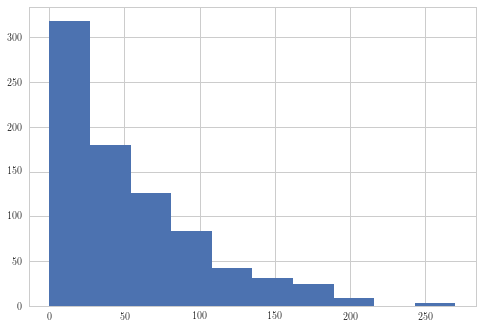

In [67]:
plt.hist(meddist)

In [62]:
filt1=(meddist<x1.max())&(meddist>x1.min())
(filt1).sum() # galaxies in range

748

In [63]:
filt2=(meddist<x2.max())&(meddist>x2.min())
(filt2).sum() # galaxies in range

749

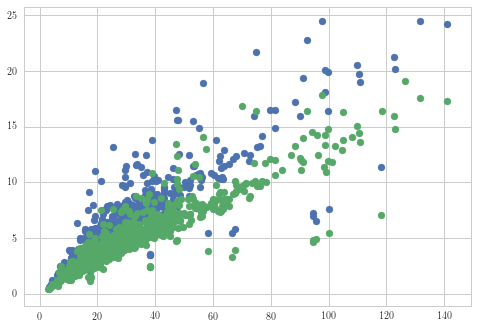

In [111]:
plt.scatter(x1,y1)
plt.scatter(x2,y2)

In [64]:
filt=np.array(em)>5
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
z=np.array(bootmad)[filt]

In [65]:
filt=np.array(em)>13
x2=np.array(dboot)[filt]
samples1=samples
filt=np.array(em)>15
x1=np.array(dboot)[filt]

In [74]:
sth1=np.median(samples1,axis=0)
sth2=np.median(samples2,axis=0)

In [95]:
x1.min(),x1.max() #this goes into filter for other databases

(3.2233139166587161, 140.96666964288357)

In [96]:
x2.min(),x2.max()

(2.8327613702075238, 140.96666964288357)

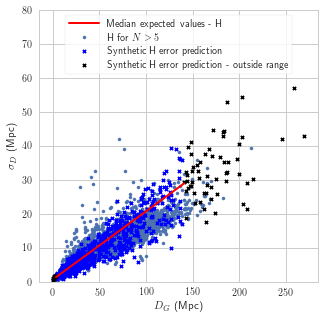

In [87]:
np.random.seed(10)
plt.figure(figsize=(5,5))
plt.scatter(x,y,s=10,label='H for $N>5$')
xp=np.linspace(x1.min(),x1.max(),2)
modpar=samples1[np.random.randint(len(samples1))]
ymod=modpar[0]*meddist+modpar[1]
ysim=np.random.normal(ymod,modpar[2]*ymod)
#plt.scatter(x1,y1,label='H for $N>15$ measurements')
mark='x'
plt.scatter(meddist[filt1],ysim[filt1], c='b',s=10,marker=mark,label='Synthetic H error prediction')
plt.scatter(meddist[~filt1],ysim[~filt1], c='k',s=10,marker=mark,label='Synthetic H error prediction - outside range')
plt.plot(xp,xp*sth1[0]+sth1[1],c='r',linewidth=2,label='Median expected values - H')
plt.ylim(0,80)
plt.legend(frameon=True,loc='upper center')
plt.xlabel('$D_G$ (Mpc)')
plt.ylabel('$\sigma_D$ (Mpc)')
plt.savefig('mnras/predl1.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/predl1.png', dpi=reso,transparent=True)

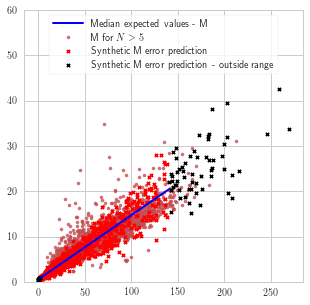

In [97]:
np.random.seed(10)
plt.figure(figsize=(5,5))
plt.scatter(x,z,c=current_palette[2],s=10,label='M for $N>5$',alpha=0.8)
xp=np.linspace(x2.min(),x2.max(),2)
modpar=samples2[np.random.randint(len(samples2))]
ymod=modpar[0]*meddist+modpar[1]
ysim=np.random.normal(ymod,modpar[2]*ymod)
#plt.scatter(x2,y2,c=current_palette[1],label='M for $N>13$ measurements')
mark='x'
plt.scatter(meddist[filt2],ysim[filt2], c='r',s=10,marker=mark,label='Synthetic M error prediction')
plt.scatter(meddist[~filt2],ysim[~filt2], c='k',s=10,marker=mark,label='Synthetic M error prediction - outside range')
plt.plot(xp,xp*sth2[0]+sth2[1],c='b',linewidth=2,label='Median expected values - M')
plt.ylim(0,60)
plt.legend(frameon=True,loc='upper center')
plt.savefig('mnras/predl2.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/predl2.png', dpi=reso,transparent=True)

In [313]:
np.savetxt('posterior_lh.txt',samples)

In [314]:
np.savetxt('posterior_lm.txt',samples2)

In [8]:
samples1=np.loadtxt('posterior_lh.txt')

In [9]:
samples2=np.loadtxt('posterior_lm.txt')

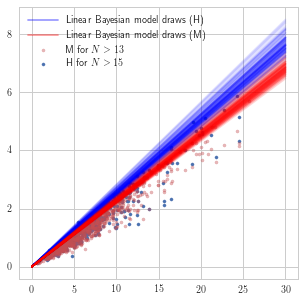

In [38]:
plt.figure(figsize=(5,5))
di=np.linspace(0,30,2)
for m, b,f in samples1[np.random.randint(len(samples1), size=100)]:
    plt.plot(di, f*di, zorder=1, color="b", alpha=0.1)
plt.plot(di, f*di,color="b", alpha=0.4,label="Linear Bayesian model draws (H)")
for m, b,f in samples2[np.random.randint(len(samples2), size=100)]:
    plt.plot(di, f*di, color="r", alpha=0.1)
plt.plot(di, f*di, color="r", alpha=0.4,label="Linear Bayesian model draws (M)")
filt=np.array(em)>13
y=np.array(bootp50)[filt]
ms=np.array(bootmsig)[filt]
plt.scatter(y,ms,s=10,c=current_palette[2],alpha=0.4,label='M for $N>13$',zorder=2)
filt=np.array(em)>15
y=np.array(bootp50)[filt]
ee=np.array(bootsig)[filt]
plt.scatter(y,ee,s=10,c=current_palette[0],alpha=1,label='H for $N>15$',zorder=1)
plt.legend()
plt.savefig('mnras/drawsee.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/drawsee.png', dpi=reso,transparent=True)

In [22]:
ndf.meas[ndf.meas>13].sum()

12947

In [23]:
ndf.meas[ndf.meas>15].sum()

9269

In [24]:
ndf.meas[ndf.meas>25].sum()

812